<a href="https://colab.research.google.com/github/dory7137/Visiting-home-project/blob/main/COVID19_project/covid_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make sure you open it in Google Colab to see all the diagrams!

This jupyter notebook file contains the documentation of the code, show all the analysis and result and explicitly testing the code itself as runing all codeparts.

For this project I used the "JHU CSSE COVID-19 Data" url: https://github.com/CSSEGISandData/COVID-19

I also used these articles and code parts from towardsdatascience.com:
 
https://towardsdatascience.com/infectious-disease-modelling-part-i-understanding-sir-28d60e29fdfc
https://towardsdatascience.com/infectious-disease-modelling-beyond-the-basic-sir-model-216369c584c4
https://towardsdatascience.com/infectious-disease-modelling-fit-your-model-to-coronavirus-data-2568e672dbc7


First, import all necessary libraries

In [ ]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.integrate import odeint
!pip install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian
from datetime import datetime as dt
import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 266kB 5.8MB/s 
     |████████████████████████████████| 61kB 6.0MB/s 
     |████████████████████████████████| 256kB 35.1MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.1-cp36-none-any.whl size=81991 sha256=cdf9aa2d625375de19eed133c6b9cfe8416038aeed148936caf53880b849a44e
  Stored in directory: /root/.cache/pip/wheels/ef/22/8d/6cd9c0af36f501cfb248673b05dad5d2c27504951d55519acb
  Created wheel for asteval: filename=asteval-0.9.21-cp36-none-any.whl size=17287 sha256=00afa171290671c9f17f6195983aa03351f2c4447967c6c73561e81dba8a2f53
  Stored in directory: /root/.cache/pip/wheels/53/9d/3b/da1ff15feb7d97bb195837f4e78f971c748a945bd4720003ce
Successfully built lmfit asteval


Read the data to a pandas dataframe from the .CSV files from the JHU CSSE COVID-19 github repository using pandas library.

Printing out these dataframes' first few rows to test the file reading.

In [ ]:
confirmed_cases=pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
deaths_cases=pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
recovered_cases=pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

In [ ]:
confirmed_cases.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,40026,40073,40141,40200,40287,40357,40510,40626,40687,40768,40833,40937,41032,41145,41268,41334,41425,41501,41633,41728,41814,41935,41975,42033,42092,42297,42463,42609,42795,42969,43035,43240,43403,43628,43851,44228,44443,44503,44706,44988
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,16212,16501,16774,17055,17350,17651,17948,18250,18556,18858,19157,19445,19729,20040,20315,20634,20875,21202,21523,21904,22300,22721,23210,23705,24206,24731,25294,25801,26211,26701,27233,27830,28432,29126,29837,30623,31459,32196,32761,33556
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,53777,53998,54203,54402,54616,54829,55081,55357,55630,55880,56143,56419,56706,57026,57332,57651,57942,58272,58574,58979,59527,60169,60800,61381,62051,62693,63446,64257,65108,65975,66819,67679,68589,69591,70629,71652,72755,73774,74862,75867
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3190,3377,3377,3377,3623,3623,3811,3811,4038,4038,4038,4325,4410,4517,4567,4665,4756,4825,4888,4910,5045,5135,5135,5319,5383,5437,5477,5567,5616,5725,5725,5872,5914,5951,6018,6066,6142,6207,6256,6304
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7096,7222,7462,7622,7829,8049,8338,8582,8829,9026,9381,9644,9871,10074,10269,10558,10805,11035,11228,11577,11813,12102,12223,12335,12433,12680,12816,12953,13053,13228,13374,13451,13615,13818,13922,14134,14267,14413,14493,14634


In [ ]:
deaths_cases.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1481,1485,1488,1492,1497,1499,1501,1505,1507,1511,1514,1518,1523,1529,1532,1533,1536,1536,1541,1544,1548,1554,1554,1556,1558,1574,1577,1581,1591,1595,1605,1617,1626,1638,1645,1650,1661,1675,1687,1695
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,439,443,448,451,454,458,462,465,469,473,477,480,487,493,499,502,509,518,527,532,536,543,549,557,559,571,579,590,598,605,612,623,631,637,646,657,672,685,699,716
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1827,1841,1846,1856,1865,1873,1880,1888,1897,1907,1914,1922,1931,1941,1949,1956,1964,1973,1980,1980,1999,2011,2024,2036,2048,2062,2077,2093,2111,2124,2139,2154,2168,2186,2206,2224,2236,2255,2272,2294
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,59,59,59,59,62,62,63,63,69,69,69,72,72,72,73,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,76,76,76,76,76,76,76,76,76
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,228,234,241,247,248,251,255,260,265,267,268,270,271,275,275,279,284,286,289,291,296,299,300,303,307,308,308,312,315,317,322,322,324,328,332,333,334,336,337,337


In [ ]:
recovered_cases.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,33447,33516,33561,33614,33760,33790,33824,33831,34010,34023,34129,34150,34217,34237,34239,34258,34321,34326,34342,34355,34362,34440,34440,34446,34458,34721,34954,34967,35024,35036,35067,35092,35137,35160,35295,35350,35370,35422,35934,35976
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,9864,9957,10001,10071,10167,10225,10341,10395,10466,10548,10654,10705,10808,10893,11007,11097,11189,11246,11367,11473,11578,11696,11861,12002,12092,12203,12353,12493,12574,12667,12767,12889,13453,13804,14216,14565,15055,15469,15842,16230
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,37603,37856,37971,38088,38215,38346,38482,38618,38788,38932,39095,39273,39444,39635,39635,40014,40201,40395,40577,40577,41001,41244,41510,41783,42037,42325,42626,42980,42980,43779,44199,44633,45148,45148,46326,46962,47581,48183,48794,49421
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2011,2057,2057,2057,2273,2273,2470,2470,2729,2729,2729,2957,3029,3144,3260,3377,3475,3475,3548,3627,3734,3858,3858,4043,4248,4332,4405,4488,4585,4675,4675,4747,4830,4965,5055,5127,5239,5290,5358,5405
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2928,3012,3022,3030,3031,3037,3040,3305,3384,3461,3508,3530,3647,3693,3736,4107,4523,4920,5172,5230,5266,5350,5626,5647,5899,5927,6036,6125,6250,6326,6345,6444,6523,6582,6623,7062,7117,7273,7346,7351


Choosing the Hungarian and Irish data

In [ ]:
confirmed_ie_hu=confirmed_cases[(confirmed_cases["Country/Region"]=="Ireland") | (confirmed_cases["Country/Region"]=="Hungary") ].reset_index(drop=True)
deaths_ie_hu=deaths_cases[(deaths_cases["Country/Region"]=="Ireland") | (deaths_cases["Country/Region"]=="Hungary") ].reset_index(drop=True)
recovered_ie_hu=recovered_cases[(recovered_cases["Country/Region"]=="Ireland") | (recovered_cases["Country/Region"]=="Hungary") ].reset_index(drop=True)

Delete the columns that I won't use for this analysis

In [ ]:
del confirmed_ie_hu["Province/State"]
del confirmed_ie_hu["Lat"]
del confirmed_ie_hu["Long"]

del deaths_ie_hu["Province/State"]
del deaths_ie_hu["Lat"]
del deaths_ie_hu["Long"]

del recovered_ie_hu["Province/State"]
del recovered_ie_hu["Lat"]
del recovered_ie_hu["Long"]

Pivoting the tables. It makes the visualisation part easier. 

Print out the last part of the data to test the pivoting.

In [ ]:
confirmed_ie_hu=confirmed_ie_hu.pivot_table(columns=["Country/Region"]).reset_index()
confirmed_ie_hu.rename(columns = {'index': "Date", "Hungary": "Hungary_C", "Ireland": "Ireland_C"}, inplace=True)
confirmed_ie_hu['Date']=pd.to_datetime(confirmed_ie_hu['Date'],format='%m/%d/%y') 
confirmed_ie_hu.sort_values(by= 'Date').reset_index(inplace=True)
confirmed_ie_hu.tail()

Country/Region,Date,Hungary_C,Ireland_C
302,2020-09-05,7892,29534
303,2020-09-06,8387,29672
304,2020-09-07,8963,29774
305,2020-09-08,9304,30080
306,2020-09-09,9715,30164


In [ ]:
deaths_ie_hu=deaths_ie_hu.pivot_table(columns=["Country/Region"]).reset_index(drop=False)
deaths_ie_hu.rename(columns = {'index': "Date", "Hungary": "Hungary_D", "Ireland": "Ireland_D"}, inplace=True)
deaths_ie_hu['Date']=pd.to_datetime(deaths_ie_hu['Date'],format='%m/%d/%y') 
deaths_ie_hu=deaths_ie_hu.sort_values(by= 'Date')
deaths_ie_hu.set_index("Date", inplace = True)
confirmed_ie_hu.tail()

Country/Region,Date,Hungary_C,Ireland_C
302,2020-09-05,7892,29534
303,2020-09-06,8387,29672
304,2020-09-07,8963,29774
305,2020-09-08,9304,30080
306,2020-09-09,9715,30164


In [ ]:
recovered_ie_hu=recovered_ie_hu.pivot_table(columns=["Country/Region"]).reset_index(drop=False)
recovered_ie_hu.rename(columns = {'index': "Date", "Hungary": "Hungary_R", "Ireland": "Ireland_R"}, inplace=True)
recovered_ie_hu['Date']=pd.to_datetime(recovered_ie_hu['Date'],format='%m/%d/%y') 
recovered_ie_hu=recovered_ie_hu.sort_values(by= 'Date')
recovered_ie_hu.set_index("Date",  inplace=True)
recovered_ie_hu.tail()

Country/Region,Hungary_R,Ireland_R
Date,,
2020-11-19,36345,23364
2020-11-20,38074,23364
2020-11-21,40820,23364
2020-11-22,42915,23364
2020-11-23,43339,23364


Merge the three tables into one table. 

In [ ]:
all_data=pd.merge(confirmed_ie_hu,deaths_ie_hu, left_on="Date",right_on="Date").merge(recovered_ie_hu, left_on="Date",right_on="Date")
all_data=all_data.sort_values(by="Date", ignore_index=True).reset_index(drop=True)


Add a new column for the active cases which is the difference between all confirmed cases and the number of the deaths and recovered cases.
Print out the last 10 lines to test the calculation.

In [ ]:
all_data["Hungary_A"]=all_data["Hungary_C"]-all_data["Hungary_D"]-all_data["Hungary_R"]
all_data["Ireland_A"]=all_data["Ireland_C"]-all_data["Ireland_D"]-all_data["Ireland_R"]
all_data.tail(10)

Country/Region,Date,Hungary_C,Ireland_C,Hungary_D,Ireland_D,Hungary_R,Ireland_R,Hungary_A,Ireland_A
297,2020-11-14,136723,67526,2990,1978,31126,23364,102607,42184
298,2020-11-15,140961,67903,3097,1979,31599,23364,106265,42560
299,2020-11-16,147456,68356,3190,1984,34010,23364,110256,43008
300,2020-11-17,152659,68686,3281,1995,34185,23364,115193,43327
301,2020-11-18,156949,69058,3380,2006,34846,23364,118723,43688
302,2020-11-19,161461,69473,3472,2010,36345,23364,121644,44099
303,2020-11-20,165901,69802,3568,2018,38074,23364,124259,44420
304,2020-11-21,170298,70143,3689,2022,40820,23364,125789,44757
305,2020-11-22,174618,70461,3800,2023,42915,23364,127903,45074
306,2020-11-23,177952,70711,3891,2023,43339,23364,130722,45324


Because the EU Green list definition uses a ratio for 100.000 inhabitants, I calculate this for Hungary and Ireland too.

In [ ]:
hungarian_population=9773000
irish_population=4953000
hungarian_rate=100000/hungarian_population
irish_rate=100000/irish_population

To visualize the data of these two countries define a function named data_plotter.

In [ ]:
def data_plotter(plt_type, splot_size, xaxis_data, first_dataset, second_dataset, fig_title, fig_ylabel, fig_legend):
    
    if plt_type == "cumulate":
        plt.subplot(splot_size[0], splot_size[1], splot_size[2])
        plt.plot(xaxis_data,first_dataset)
        plt.plot(xaxis_data,second_dataset)
        plt.xticks(rotation=45)
        plt.title(fig_title)
        plt.ylabel(fig_ylabel)
        plt.legend(fig_legend)
        plt.grid(b=True, alpha=0.5)
        #for 100.000 habitants
        plt.subplot(splot_size[0], splot_size[1], splot_size[2]+1)
        plt.plot(xaxis_data,first_dataset*hungarian_rate)
        plt.plot(xaxis_data,second_dataset*irish_rate)
        plt.xticks(rotation=45)
        plt.title(fig_title+" for 100.000 inhabitants")
        plt.ylabel(fig_ylabel)
        plt.legend(fig_legend)
        plt.grid(b=True, alpha=0.2)
    
    elif plt_type == "daily":
        plt.subplot(splot_size[0], splot_size[1], splot_size[2])
        plt.bar(xaxis_data, first_dataset, width=0.5)
        plt.bar(xaxis_data + pd.Timedelta(hours=12), second_dataset, width=0.5)
        plt.title(fig_title)
        plt.ylabel(fig_ylabel)
        plt.legend(fig_legend)
        plt.grid(b=True, alpha=0.5)
        plt.xticks(rotation=45)
        plt.ylim( ymin = 0)
    else:
        #TODO: raise error
        pass

Plotting the figures. The first figure represent all cases and all active cases, and these cases for 100.000 inhabitants

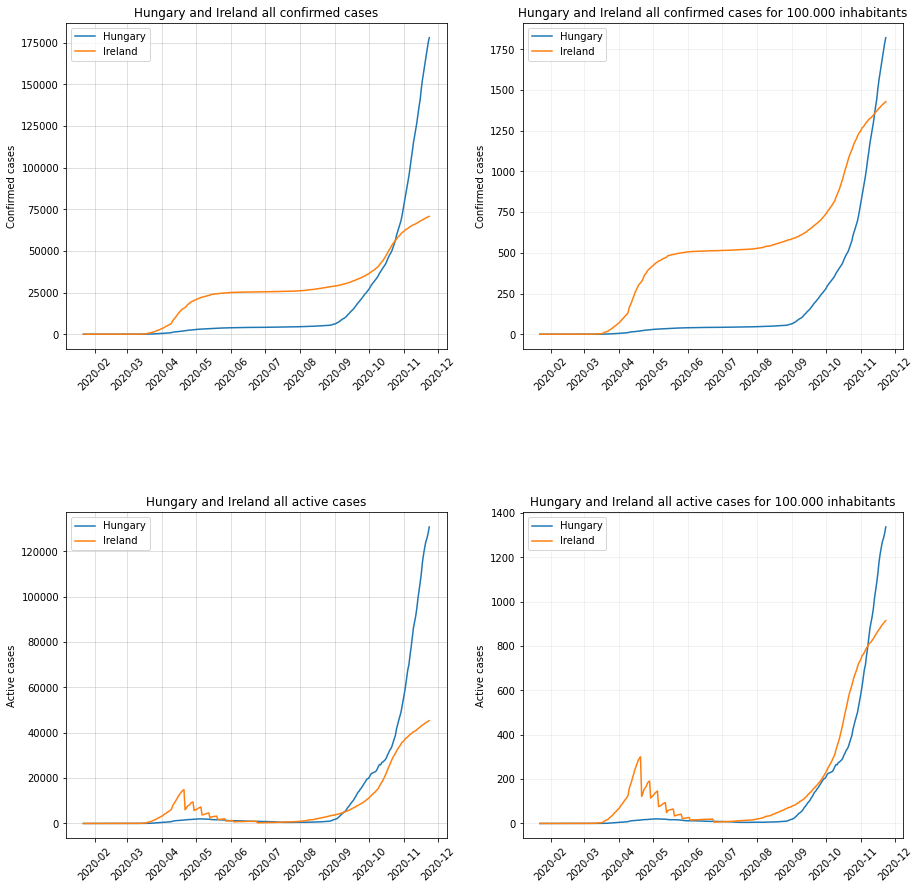

In [ ]:
figure=plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#first plot
#confirmed cases
data_plotter("cumulate",[2,2,1],all_data.Date, all_data.Hungary_C, all_data.Ireland_C, "Hungary and Ireland all confirmed cases", "Confirmed cases", ["Hungary", "Ireland"] )
#active cases
data_plotter("cumulate",[2,2,3],all_data.Date, all_data.Hungary_A, all_data.Ireland_A, "Hungary and Ireland all active cases", "Active cases", ["Hungary", "Ireland"] )
plt.show()

It's interesting that if we look at the total number of cases, there are currently more confirmed and active cases in Hungary.
However, if we look the cases for 100.000 inhabitants, it seems that the difference is smaller, in fact, before November the Hungarian cases for 100.000 inhabitants were smaller than Irish cases. The latter finding is also true for active cases.

However, it is important to note that since the number of tests and the rate of positive tests in Hungary and in Ireland are very different, it is not possible to say  anything with absolute certainty.

Next plots are for the deaths and recovered.

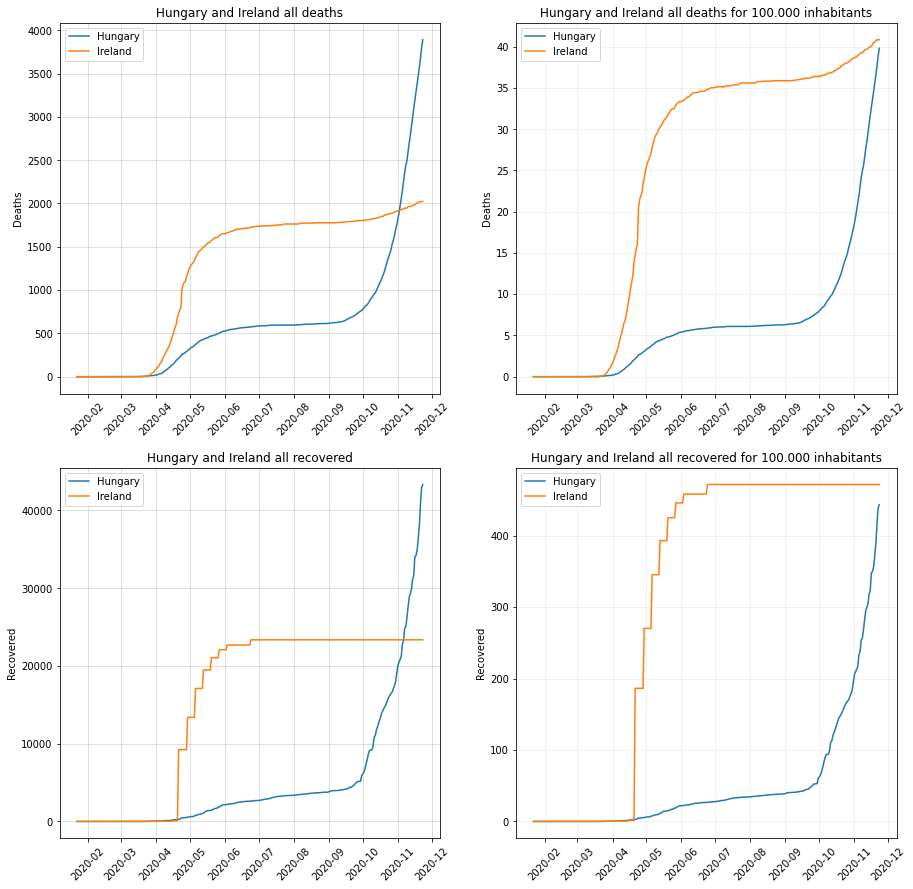

In [ ]:
#plot2
figure2=plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
#deaths
data_plotter("cumulate",[2,2,1],all_data.Date, all_data.Hungary_D, all_data.Ireland_D, "Hungary and Ireland all deaths", "Deaths", ["Hungary", "Ireland"] )
#recovered
data_plotter("cumulate",[2,2,3],all_data.Date, all_data.Hungary_R, all_data.Ireland_R, "Hungary and Ireland all recovered", "Recovered", ["Hungary", "Ireland"] )
plt.show()

The above findings are again true on the basis of the figures, if we look at the left side, we can see that the cumalted numbers are higher in Hungary but if we look at the right side, Ireland has the higher number of deaths and recovered for 100.000 inhabitants. 
In summary, the two figures above show that numbers in Ireland were worse in terms of population, but Hungary is catching up as both the number of active, infected people and deaths are growing exponentially.


Next step is to calculate the daily dataset for the confirmed, deaths,  recovered and active cases. It helps to see the changes in trends.

In [ ]:
#calculate daily data

daily_confirmed_hun =[]
daily_confirmed_ie=[]
daily_deaths_hun=[]
daily_deaths_ie=[]
daily_recovered_hun=[]
daily_recovered_ie=[]
daily_active_hun=[]
daily_active_ie=[]

# choose the data for figures

for i in range(len(all_data[["Hungary_C"]])):
    if i == 0:
        daily_confirmed_hun.append(all_data[["Hungary_C"]].iat[i,0])
        daily_confirmed_ie.append(all_data[["Ireland_C"]].iat[i, 0])
        daily_deaths_hun.append(all_data[["Hungary_D"]].iat[i, 0])
        daily_deaths_ie.append(all_data[["Ireland_D"]].iat[i, 0])
        daily_recovered_hun.append(all_data[["Hungary_R"]].iat[i, 0])
        daily_recovered_ie.append(all_data[["Ireland_R"]].iat[i, 0])
        daily_active_hun.append(all_data[["Hungary_C"]].iat[i, 0]-all_data[["Hungary_D"]].iat[i, 0]-all_data[["Hungary_R"]].iat[i, 0])
        daily_active_ie.append(all_data[["Ireland_C"]].iat[i, 0]-all_data[["Ireland_D"]].iat[i, 0]-all_data[["Ireland_R"]].iat[i, 0])

    else:
        daily_confirmed_hun.append(all_data[["Hungary_C"]].iat[i, 0] - all_data[["Hungary_C"]].iat[i-1,0])
        daily_confirmed_ie.append(all_data[["Ireland_C"]].iat[i, 0] - all_data[["Ireland_C"]].iat[i-1,0])
        daily_deaths_hun.append(all_data[["Hungary_D"]].iat[i, 0] - all_data[["Hungary_D"]].iat[i-1,0])
        daily_deaths_ie.append(all_data[["Ireland_D"]].iat[i, 0] - all_data[["Ireland_D"]].iat[i-1,0])
        daily_recovered_hun.append(all_data[["Hungary_R"]].iat[i, 0] - all_data[["Hungary_R"]].iat[i-1,0])
        daily_recovered_ie.append(all_data[["Ireland_R"]].iat[i, 0] - all_data[["Ireland_R"]].iat[i-1,0])
        hu_act=(all_data[["Hungary_C"]].iat[i, 0] - all_data[["Hungary_C"]].iat[i-1,0])-(all_data[["Hungary_D"]].iat[i, 0] - all_data[["Hungary_D"]].iat[i-1,0])- (all_data[["Hungary_R"]].iat[i, 0] - all_data[["Hungary_R"]].iat[i-1,0])
        ie_act=(all_data[["Ireland_C"]].iat[i, 0] - all_data[["Ireland_C"]].iat[i-1,0])-(all_data[["Ireland_D"]].iat[i, 0] - all_data[["Ireland_D"]].iat[i-1,0])- (all_data[["Ireland_R"]].iat[i, 0] - all_data[["Ireland_R"]].iat[i-1,0])
        daily_active_hun.append(hu_act)
        daily_active_ie.append(ie_act)


After that, I can visualize the daily cases too. 

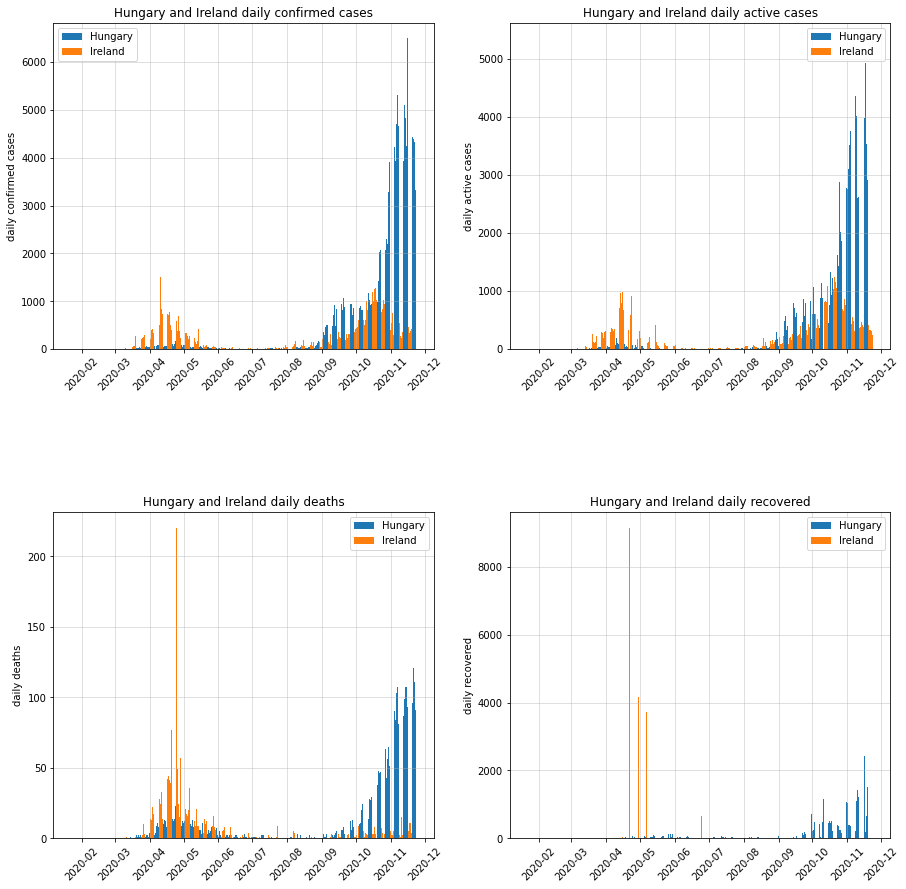

In [ ]:
figure3=plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

data_plotter("daily",[2,2,1],all_data.Date, daily_confirmed_hun, daily_confirmed_ie, "Hungary and Ireland daily confirmed cases", "daily confirmed cases", ["Hungary", "Ireland"] )
data_plotter("daily",[2,2,2],all_data.Date, daily_active_hun, daily_active_ie, "Hungary and Ireland daily active cases", "daily active cases", ["Hungary", "Ireland"] )
data_plotter("daily",[2,2,3],all_data.Date, daily_deaths_hun, daily_deaths_ie, "Hungary and Ireland daily deaths", "daily deaths", ["Hungary", "Ireland"] )
data_plotter("daily",[2,2,4],all_data.Date, daily_recovered_hun, daily_recovered_ie, "Hungary and Ireland daily recovered", "daily recovered", ["Hungary", "Ireland"] )
plt.show()

The figure shows that the first and second waves are clearly separated for both countries. It can also be seen that while in the first wave there were more daily cases in Ireland, in the second wave Hungary has more new and active cases and more deaths.

And now, let's see the daily cases for 100.000 inhabitants.

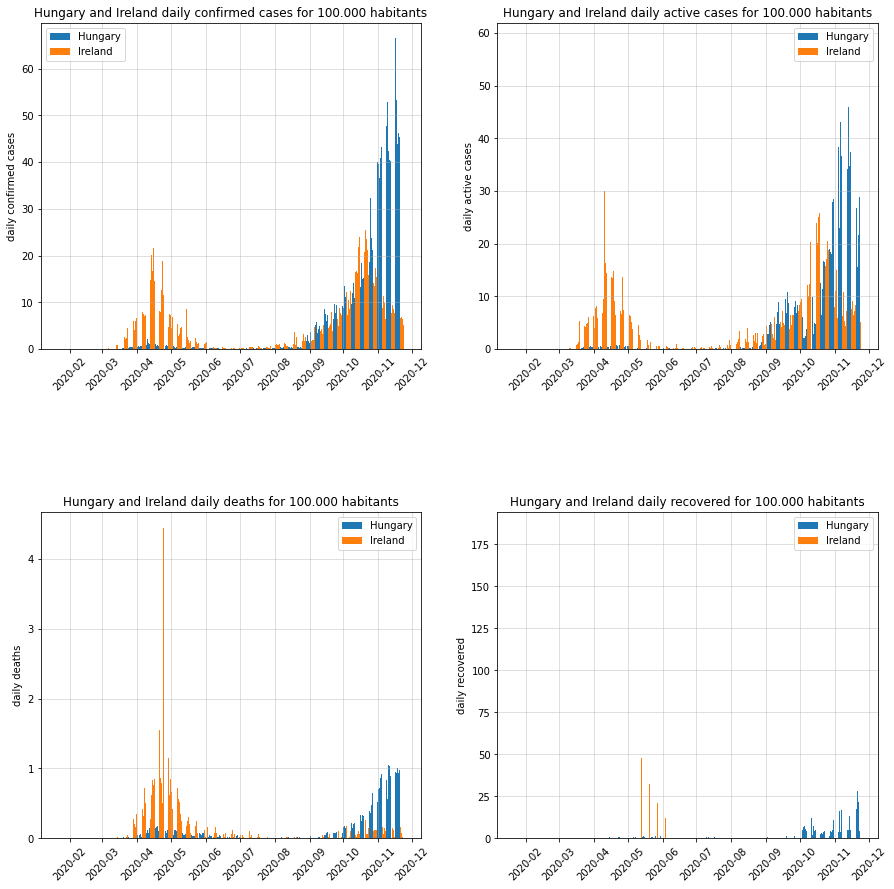

In [ ]:
daily_confirmed_hun_100K = [case*hungarian_rate for case in daily_confirmed_hun]
daily_confirmed_ie_100K = [case*irish_rate for case in daily_confirmed_ie]
daily_deaths_hun_100K = [case*hungarian_rate for case in daily_deaths_hun]
daily_deaths_ie_100K = [case*irish_rate for case in daily_deaths_ie]
daily_recovered_hun_100K = [case*hungarian_rate for case in daily_recovered_hun]
daily_recovered_ie_100K = [case*irish_rate for case in daily_recovered_ie]
daily_active_hun_100K = [case*hungarian_rate for case in daily_active_hun]
daily_active_ie_100K = [case*irish_rate for case in daily_active_ie]

figure4=plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

data_plotter("daily",[2,2,1],all_data.Date, daily_confirmed_hun_100K, daily_confirmed_ie_100K, "Hungary and Ireland daily confirmed cases for 100.000 habitants", "daily confirmed cases", ["Hungary", "Ireland"] )
data_plotter("daily",[2,2,2],all_data.Date, daily_active_hun_100K, daily_active_ie_100K, "Hungary and Ireland daily active cases for 100.000 habitants", "daily active cases", ["Hungary", "Ireland"] )
data_plotter("daily",[2,2,3],all_data.Date, daily_deaths_hun_100K, daily_deaths_ie_100K, "Hungary and Ireland daily deaths for 100.000 habitants", "daily deaths", ["Hungary", "Ireland"] )
data_plotter("daily",[2,2,4],all_data.Date, daily_recovered_hun_100K, daily_recovered_ie_100K, "Hungary and Ireland daily recovered for 100.000 habitants", "daily recovered", ["Hungary", "Ireland"] )
plt.show()


The data for 100,000 inhabitants looks more nuanced, but the previously mentioned trend remained, the first wave affected Ireland more, and it changed in the second wave.

After I get familiar with the data, it's time to write the SIR model and use that to predict the future.
If you are not familiar with the concept of SIR model please read the linked articles above from towardsdatascilence.com.
I decided to use a basic SIR (not SEIR or  SEICR model) because I want to predict the Infected numbers and the basic model is perfect for this and I can't find any public dataset about the occupied ICU beds and invasive ventillators. 

In [ ]:
# gamma: how many days takes to recover
gamma = 1.0/9.0
# phi how many days takes to die
phi = 1.0/18.0
# alpha is the fatality rate
alpha=2.3/10.0
# population number
N_hungary=hungarian_population
N_ireland=irish_population
hungarian_green_list_limit=25.0 / hungarian_rate
irish_green_list_limit=25.0 / irish_rate

In [ ]:
def data_fitting_SIR(country, N_country, green_list_limit, data_to_fit, outbreak_day, params_to_fit):

    # calculate the derivate of the SIR model elements (or the difference over time)
    def deriv(y, t, beta, gamma, phi, alpha, N):
        S, I, R, D = y
        dSdt = -beta(t) * I * S / N
        dIdt = beta(t) * I * S/N - (gamma*(1-alpha)*I) - (phi*alpha*I)
        dRdt = gamma * alpha * I
        dDdt = phi * (1-alpha)*I
        return dSdt, dIdt, dRdt, dDdt

    # the infection rate called R in this case modelling the changes over time like a logistic function
    def logistic_R_0(t, R_0_start, k, x0, R_0_end):
        return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end
    
    # the SIR model 
    def Model(days, N, R_0_start, k, x0, R_0_end):
        
        def beta(t):
            return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma

        y0 = N-1.0, 1.0, 0.0, 0.0
        t = np.linspace(0, days-1, days)
        ret = odeint(deriv, y0, t, args=(beta, gamma, phi, alpha, N ))
        S, I, R, D = ret.T
        R_0_over_time = [beta(i)/gamma for i in range(len(t))]

        return t, S, I, R, D, R_0_over_time
    
    
    # use to plot the prediction
    def plotter(t, S, I, R, D, R_0, x_ticks=None, country=""):
    
        f, ax = plt.subplots(1,1,figsize=(10,10))
        if x_ticks is None:
            ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        else:
            ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
            ax.xaxis.set_major_locator(mdates.YearLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            ax.xaxis.set_minor_locator(mdates.MonthLocator())
            f.autofmt_xdate()
        ax.title.set_text('The SIR-Model prediction of '+ country)
        ax.grid(b=True, alpha=0.5)
        legend = ax.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)
        plt.show()
        
        
    #fitting the model to the actual data 
    def fitter(x, R_0_start, k, x0, R_0_end):
        #Model(days, N, R_0_start, k, x0, R_0_end)
        ret = Model(days, N_country, R_0_start, k, x0, R_0_end)
        # index=2 -> returns I
        return ret[2][x]

    fitting_data = data_to_fit
    
    outbreak_shift = outbreak_day
    #form: {parameter: (initial guess, minimum value, max value)}
    params_init_min_max = params_to_fit  
    #if the outbreak was before the first dataset (01.22.2020)
    days = outbreak_shift + len(fitting_data)
    if outbreak_shift >= 0:
        y_data = np.concatenate((np.zeros(outbreak_shift), fitting_data))
    else:
        y_data = y_data[-outbreak_shift:]

    x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array
    
    #try to find the best values to the paramteters works regression
    mod = lmfit.Model(fitter)

    for kwarg, (init, mini, maxi) in params_init_min_max.items():
        mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

    params = mod.make_params()
    fit_method = "leastsq"

    result = mod.fit(y_data, params, method="least_squares", x=x_data)
    
    result.plot_fit(datafmt="-")
    plt.title("Fitting the model to {}'s data".format(country))
    plt.grid(b=True, alpha=0.5)
    plt.show()

    full_days = 650
    first_date = np.datetime64(all_data.Date.min()) - np.timedelta64(outbreak_shift,'D')
    x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")

    plotter(*Model(full_days, N_country, **result.best_values), x_ticks=x_ticks, country=country)

    prediction_country = Model(full_days, N_country, **result.best_values)
    active_cases_pred=prediction_country[2]

    #calculate the daily new cases
    daily_prediction_country=[]

    for i in range(len(active_cases_pred)):
        if i == 0:
            daily_prediction_country.append(active_cases_pred[i])
        else:
            daily_prediction_country.append(active_cases_pred[i]-active_cases_pred[i-1])

    

    #calculate the "green list point"
    count=daily_prediction_country.index(max(daily_prediction_country)) #after max

    #find the first element that is above of the limit after the peak
    while(daily_prediction_country[count] > green_list_limit and count <= len(daily_prediction_country)):
        count+=1

    green_list_limit_index=count

    figure_prob=plt.figure(figsize=(15,15))
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    ax_prob=plt.subplot(2,1,1)
    plt.hlines(y = green_list_limit, xmin = x_ticks[0], xmax = x_ticks[-2], color='g')
    plt.bar(x_ticks, daily_prediction_country, width=0.5)
    plt.title("{} predicted daily new cases".format(country))
    plt.ylabel("daily new cases")
    ax_prob.xaxis.set_major_locator(mdates.MonthLocator())
    ax_prob.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax_prob.xaxis.set_minor_locator(mdates.MonthLocator())
    figure_prob.autofmt_xdate()
    plt.grid(b=True, alpha=0.5)
    plt.xticks(rotation=45)
    plt.ylim( ymin = 0)
    plt.xlim(x_ticks[40], x_ticks[500])

    ##zoom in
    
    ax_zoom=plt.subplot(2,1,2)
    plt.hlines(y = green_list_limit, xmin = x_ticks[0], xmax = x_ticks[-2], color='g')
    plt.bar(x_ticks, daily_prediction_country, width=0.5)
    plt.title("{} predicted daily infected cases".format(country))
    plt.ylabel("daily infected cases")
    ax_zoom.xaxis.set_major_locator(mdates.DayLocator())
    ax_zoom.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.grid(b=True, alpha=0.5)
    plt.xticks(rotation=45)
    plt.ylim( ymin = 0, ymax=green_list_limit+500)
    plt.xlim(x_ticks[green_list_limit_index-3], x_ticks[green_list_limit_index+10])
    plt.show()


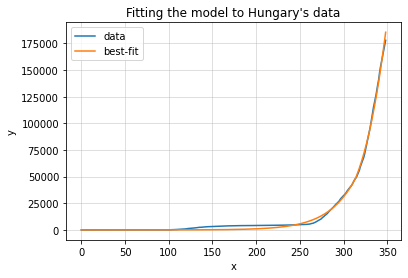

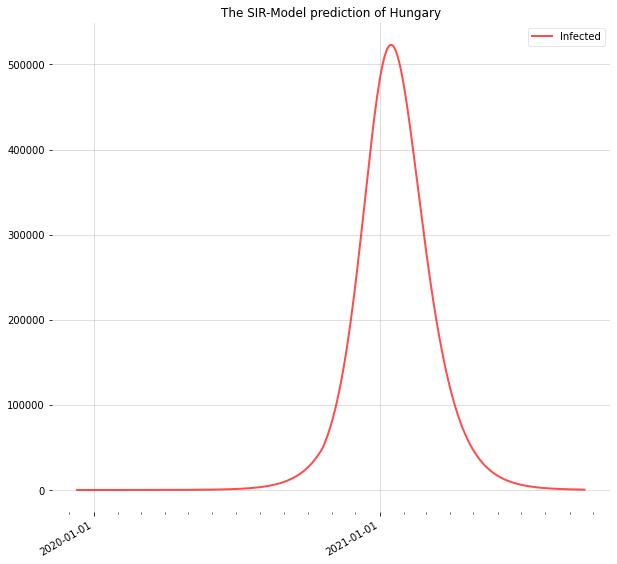

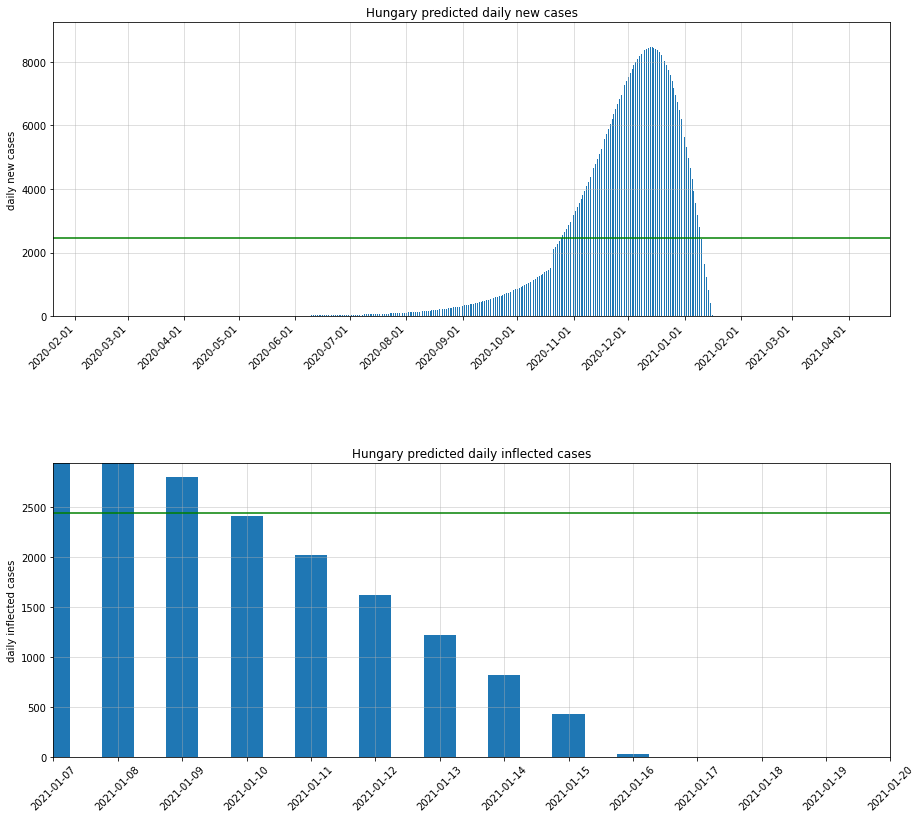

In [ ]:
data_fitting_SIR ("Hungary",N_hungary,hungarian_green_list_limit, all_data.Hungary_C, 42, {"R_0_start": (1.2, 1.0, 2.0), "k": (20.0, 1.0, 100.0), "x0": (150, 100, 400), "R_0_end": (0.8, 0.5, 2.0)})


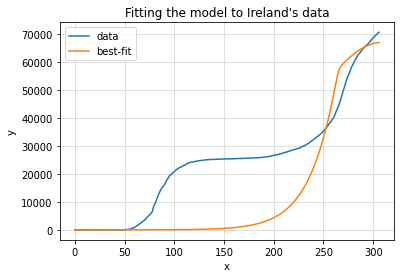

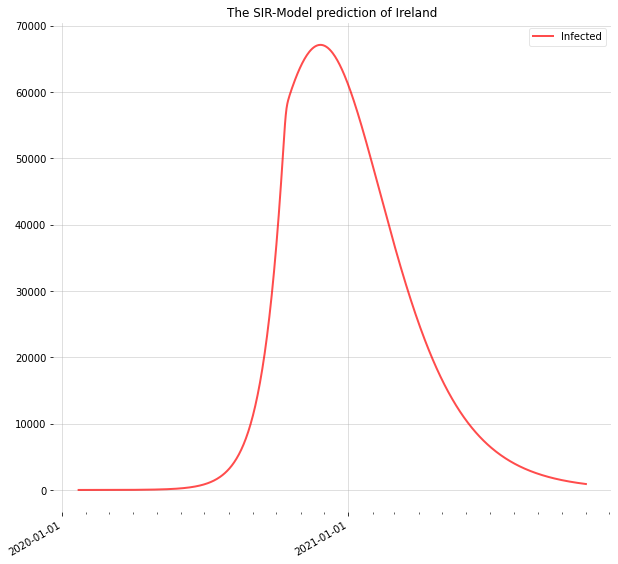

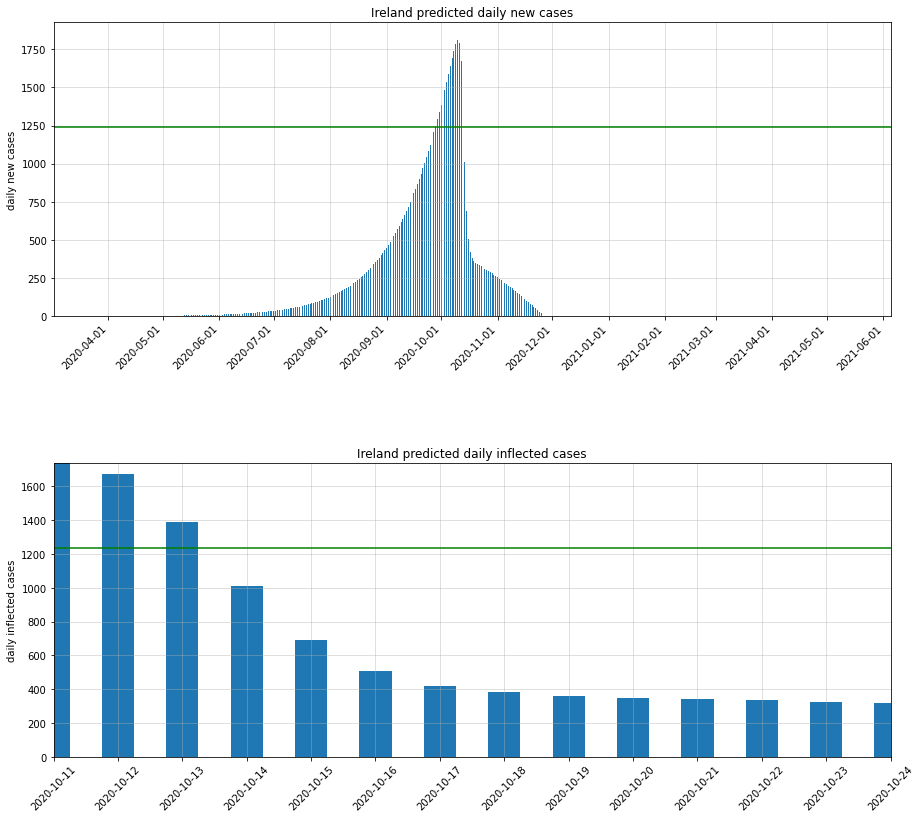

In [ ]:
data_fitting_SIR ("Ireland",N_ireland,irish_green_list_limit, all_data.Ireland_C, 0, {"R_0_start": (1.5, 1.2, 2.0), "k": (40.0, 1.0, 100.0), "x0": (270, 265, 400), "R_0_end": (1.1, 0.98, 2.0)})